In [ ]:
from PIL import Image

img = Image.open(r"Nutrition5K/Nutrition5K/train/color/dish_0000/rgb.png")
print(img.size) 

(640, 480)


In [ ]:
import sys, numpy as np, torch
sys.path.append("/mnt/data")                   
import segmentation_integration as seg           

def make_6ch_from_row(row, root_dir="."):
    """
    从一条 CSV 记录构建 6 通道输入：
    [RGB(3) + depth(1) + plate_mask(1) + food_mask(1)]，并返回 (x6 [1,6,H,W], mask1 [1,1,H,W])
    """
    out = seg.segment_row(row, root_dir=root_dir, plate_method="recommended", save_dir=None)
    rgb, depth = out["rgb"], out["depth"]
    plate_mask = (out["plate_mask"] > 0).astype(np.float32)
    food_mask  = (out["food_mask"]  > 0).astype(np.float32)

    # --- 归一化 ---
    # RGB -> [0,1]
    rgb_t = torch.from_numpy(rgb).permute(2,0,1).float() / 255.0          # [3,H,W]
    # Depth -> min-max 到 [0,1]
    depth_np = depth.astype(np.float32)
    dmin, dmax = depth_np.min(), depth_np.max()
    if dmax > dmin:
        depth_np = (depth_np - dmin) / (dmax - dmin)
    else:
        depth_np[:] = 0.0
    depth_t = torch.from_numpy(depth_np).unsqueeze(0).float()             # [1,H,W]
    # Masks -> {0,1}
    plate_t = torch.from_numpy(plate_mask).unsqueeze(0)                   # [1,H,W]
    food_t  = torch.from_numpy(food_mask).unsqueeze(0)                    # [1,H,W]

    x6 = torch.cat([rgb_t, depth_t, plate_t, food_t], dim=0).unsqueeze(0) # [1,6,H,W]
    mask1 = plate_t.unsqueeze(0)                                          # [1,1,H,W] 
    return x6, mask1, out


In [ ]:
import pandas as pd
from pathlib import Path

import sys
import segmentation_integration as seg

csv_path = "train_index.csv"   
root_dir = "."                          
df = pd.read_csv(csv_path)
df.head()


,dish_id,label,rgb_path,depth_color_path,depth_raw_path
0,dish_0000,221.167068,Nutrition5K\Nutrition5K\train\color\dish_0000\...,Nutrition5K\Nutrition5K\train\depth_color\dish...,Nutrition5K\Nutrition5K\train\depth_raw\dish_0...
1,dish_0001,140.980011,Nutrition5K\Nutrition5K\train\color\dish_0001\...,Nutrition5K\Nutrition5K\train\depth_color\dish...,Nutrition5K\Nutrition5K\train\depth_raw\dish_0...
2,dish_0002,274.335999,Nutrition5K\Nutrition5K\train\color\dish_0002\...,Nutrition5K\Nutrition5K\train\depth_color\dish...,Nutrition5K\Nutrition5K\train\depth_raw\dish_0...
3,dish_0003,589.501648,Nutrition5K\Nutrition5K\train\color\dish_0003\...,Nutrition5K\Nutrition5K\train\depth_color\dish...,Nutrition5K\Nutrition5K\train\depth_raw\dish_0...
4,dish_0004,258.599670,Nutrition5K\Nutrition5K\train\color\dish_0004\...,Nutrition5K\Nutrition5K\train\depth_color\dish...,Nutrition5K\Nutrition5K\train\depth_raw\dish_0...


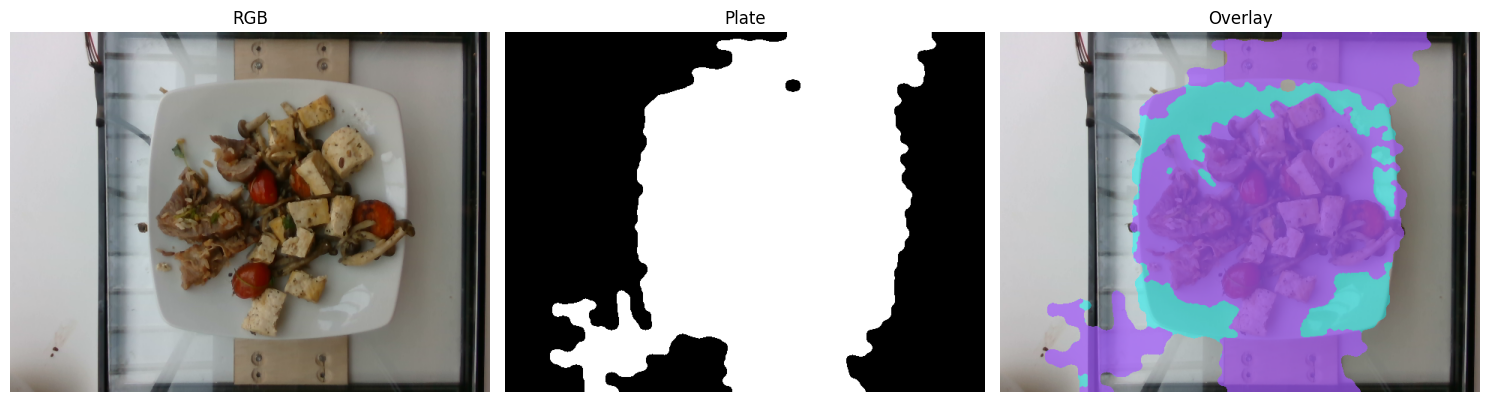

In [4]:
row = df.iloc[0].to_dict()   # 换成你要看的索引
out = seg.segment_row(row, root_dir=root_dir, plate_method="recommended", save_dir="one_demo")

rgb           = out["rgb"]
plate_mask    = out["plate_mask"]       # 0/255
food_mask     = out["food_mask"]        # 0/255
background    = out["background_mask"]  # 0/255
overlay       = out["overlay"]          # 可视化叠加

# 如果需要：显示
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(rgb); plt.title("RGB"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(plate_mask, cmap="gray"); plt.title("Plate"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
plt.tight_layout(); plt.show()


In [ ]:
summary = seg.build_masks_for_csv(
    csv_path, root_dir=root_dir,
    out_dir="seg_outputs",
    max_rows=None,               
    plate_method="recommended"     
)
summary.head()


,dish_id,rgb,depth,plate_px,food_px,plate_cov,food_of_plate,saved_dir,error
0,dish_0000,Nutrition5K\Nutrition5K\train\color\dish_0000\...,Nutrition5K\Nutrition5K\train\depth_raw\dish_0...,155851.0,125279.0,0.507327,0.803838,/Users/danica/Documents/GitHub/CV-group-projec...,NaN
1,dish_0001,Nutrition5K\Nutrition5K\train\color\dish_0001\...,Nutrition5K\Nutrition5K\train\depth_raw\dish_0...,193022.0,138142.0,0.628327,0.715680,/Users/danica/Documents/GitHub/CV-group-projec...,NaN
2,dish_0002,Nutrition5K\Nutrition5K\train\color\dish_0002\...,Nutrition5K\Nutrition5K\train\depth_raw\dish_0...,218201.0,187616.0,0.710290,0.859831,/Users/danica/Documents/GitHub/CV-group-projec...,NaN
3,dish_0003,Nutrition5K\Nutrition5K\train\color\dish_0003\...,Nutrition5K\Nutrition5K\train\depth_raw\dish_0...,194152.0,165582.0,0.632005,0.852765,/Users/danica/Documents/GitHub/CV-group-projec...,NaN
4,dish_0004,Nutrition5K\Nutrition5K\train\color\dish_0004\...,Nutrition5K\Nutrition5K\train\depth_raw\dish_0...,140023.0,91799.0,0.455804,0.655521,/Users/danica/Documents/GitHub/CV-group-projec...,NaN


In [ ]:
npz_path = seg.make_supervised_npz(
    csv_path, root_dir=root_dir,
    out_dir="seg_outputs",
    classes=("background","plate","food"),
    max_rows=500,        
    resize_to=(256,256) 
)
npz_path

'seg_outputs/dataset.npz'

In [7]:
import numpy as np
data = np.load("seg_outputs/dataset.npz", allow_pickle=True)
X, y = data["X"], data["y"]
X.shape, y.shape, data["classes"]


((500, 256, 256, 3),
 (500, 256, 256),
 array(['background', 'plate', 'food'], dtype='<U10'))

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBNReLU(nn.Module):
    """Basic conv block: Conv -> BN -> ReLU"""
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch, eps=1e-5, momentum=0.1)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class TinyCNN(nn.Module):
    """
    Ultra-small CNN for RGB-D regression.
    - Early fusion: set in_ch=4 to accept RGB(3)+Depth(1)
    - By default uses standard GAP (no mask).
    - You can enable masked-GAP later via use_mask=True and passing a mask tensor to forward().
    """
    def __init__(self, in_ch=4, widths=(24, 48, 96, 128), dropout=0.3, out_dim=1, use_mask: bool=False):
        super().__init__()
        self.use_mask = use_mask
        w1, w2, w3, w4 = widths

        # Stem -> H/2
        self.stem = nn.Sequential(
            ConvBNReLU(in_ch, w1, k=3, s=2, p=1),
            ConvBNReLU(w1, w1, k=3, s=1, p=1),
        )
        # Stage1 -> H/4
        self.stage1 = nn.Sequential(
            ConvBNReLU(w1, w2, k=3, s=2, p=1),
            ConvBNReLU(w2, w2, k=3, s=1, p=1),
        )
        # Stage2 -> H/8
        self.stage2 = nn.Sequential(
            ConvBNReLU(w2, w3, k=3, s=2, p=1),
            ConvBNReLU(w3, w3, k=3, s=1, p=1),
        )
        # Stage3 -> H/16
        self.stage3 = nn.Sequential(
            ConvBNReLU(w3, w4, k=3, s=2, p=1),
            ConvBNReLU(w4, w4, k=3, s=1, p=1),
        )

        # Head: GAP/Masked-GAP -> Dropout -> MLP(128) -> Linear(out_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc1     = nn.Linear(w4, 128)
        self.fc2     = nn.Linear(128, out_dim)  # regression head (no activation)

    def forward_features(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)   # [B, C, H/16, W/16]
        return x

    @staticmethod
    def masked_gap(feat: torch.Tensor, mask: torch.Tensor | None):
        """
        Optional masked global average pooling.
        If mask is None, this falls back to standard GAP outside this method.
        """
        if mask is None:
            # Should not be called when mask=None; kept for completeness.
            return F.adaptive_avg_pool2d(feat, 1).flatten(1)
        m = F.interpolate(mask, size=feat.shape[-2:], mode="nearest").clamp(0, 1)  # [B,1,Hf,Wf]
        num = (feat * m).sum(dim=(2,3))           # [B,C]
        den = (m.sum(dim=(2,3)) + 1e-6)           # [B,1]
        return num / den

    def forward(self, x, mask: torch.Tensor | None = None):
        """
        x:    [B, in_ch, H, W]  (e.g., in_ch=4 for RGB-D)
        mask: [B, 1, H, W] or None. Ignored unless self.use_mask is True.
        """
        f = self.forward_features(x)
        if self.use_mask:
            # Use masked-GAP ONLY when explicitly enabled and mask is provided.
            pooled = self.masked_gap(f, mask)
        else:
            # Standard GAP (default baseline, no mask involved).
            pooled = F.adaptive_avg_pool2d(f, 1).flatten(1)

        z = self.dropout(pooled)
        z = F.relu(self.fc1(z), inplace=True)
        out = self.fc2(z)  # [B, out_dim]
        return out



In [ ]:
# ------- tiny self-test (no depth: RGB + plate + food = 5ch) -------
if __name__ == "__main__":
    import torch, numpy as np

    H, W = rgb.shape[:2]

    # 1) 准备 5 通道：RGB(3) + plate(1) + food(1)
    rgb_t   = torch.from_numpy(rgb).permute(2,0,1).float() / 255.0          # [3,H,W]
    plate_t = torch.from_numpy((plate_mask > 0).astype(np.float32)).unsqueeze(0)  # [1,H,W]
    food_t  = torch.from_numpy((food_mask  > 0).astype(np.float32)).unsqueeze(0)  # [1,H,W]

    x5 = torch.cat([rgb_t, plate_t, food_t], dim=0).unsqueeze(0)            # [1,5,H,W]

    # 2) 模型通道数要和输入一致：in_ch=5
    model = TinyCNN(in_ch=5, widths=(24,48,96,128), dropout=0.3, out_dim=1, use_mask=True)

    # 3) 可选：用盘子掩膜做 masked-GAP（mask 形状 [B,1,H,W]，数值0/1）
    y = model(x5, mask=plate_t.unsqueeze(0))
    print("5-ch (RGB+plate+food) output:", y.shape)


5-ch (RGB+plate+food) output: torch.Size([1, 1])


In [10]:
import os, csv, random, math, time
from typing import Tuple, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------- TinyCNN ----------------------
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch, eps=1e-5, momentum=0.1)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class TinyCNN(nn.Module):
    def __init__(self, in_ch=6, widths=(24,48,96,128), dropout=0.3, out_dim=1, use_mask: bool=False):
        super().__init__()
        self.use_mask = use_mask
        w1,w2,w3,w4 = widths
        self.stem  = nn.Sequential(ConvBNReLU(in_ch,w1,3,2,1), ConvBNReLU(w1,w1,3,1,1))
        self.s1    = nn.Sequential(ConvBNReLU(w1,w2,3,2,1),  ConvBNReLU(w2,w2,3,1,1))
        self.s2    = nn.Sequential(ConvBNReLU(w2,w3,3,2,1),  ConvBNReLU(w3,w3,3,1,1))
        self.s3    = nn.Sequential(ConvBNReLU(w3,w4,3,2,1),  ConvBNReLU(w4,w4,3,1,1))
        self.drop  = nn.Dropout(dropout)
        self.fc1   = nn.Linear(w4, 128)
        self.fc2   = nn.Linear(128, out_dim)
    def forward(self, x):
        f = self.s3(self.s2(self.s1(self.stem(x))))
        z = F.adaptive_avg_pool2d(f, 1).flatten(1)
        z = self.drop(F.relu(self.fc1(z), inplace=True))
        return self.fc2(z)

# ---------------------- Dataset ----------------------
class RGBDUnifiedDataset(Dataset):
    """CSV columns: dish_id,label,rgb_path,depth_color_path,depth_raw_path"""
    def __init__(self, csv_file, out_size=(384,384), augment=True, mode="rgb+drgb",
                 mean_rgb=(0.485,0.456,0.406), std_rgb=(0.229,0.224,0.225),
                 mean_drgb=(0.5,0.5,0.5), std_drgb=(0.25,0.25,0.25),
                 depth_raw_clip=(0.0,3.0)):
        super().__init__()
        self.mode, self.H, self.W = mode, *out_size
        self.augment = augment
        self.depth_raw_clip = depth_raw_clip

        # parse CSV
        self.rows = []
        with open(csv_file, "r") as f:
            reader = csv.reader(f)
            header = next(reader)
            col = {h:i for i,h in enumerate(header)}
            for r in reader:
                self.rows.append({
                    "dish_id": r[col["dish_id"]],
                    "label": float(r[col["label"]]),
                    "rgb": r[col["rgb_path"]].replace("\\", "/"),
                    "drgb": r[col["depth_color_path"]].replace("\\", "/"),
                    "draw": r[col["depth_raw_path"]].replace("\\", "/"),
                })
        # normalization
        self.mean_rgb = torch.tensor(mean_rgb).view(3,1,1)
        self.std_rgb  = torch.tensor(std_rgb ).view(3,1,1)
        self.mean_drgb= torch.tensor(mean_drgb).view(3,1,1)
        self.std_drgb = torch.tensor(std_drgb ).view(3,1,1)

    def _load_img(self, p): return TF.to_tensor(Image.open(p).convert("RGB"))
    def _load_raw(self, p):
        arr = np.array(Image.open(p)).astype("float32")
        if arr.max() > 50: arr /= 1000.0
        dmin,dmax = self.depth_raw_clip
        arr = np.clip(arr,dmin,dmax); arr = (arr-dmin)/max(1e-6,(dmax-dmin))
        return torch.from_numpy(arr).unsqueeze(0)

    def _geom_sync(self,a,b):
        if self.augment:
            scale=random.uniform(0.7,1.0)
            h,w=a.shape[-2:]; th,tw=int(h*scale),int(w*scale)
            i=random.randint(0,h-th) if th<h else 0
            j=random.randint(0,w-tw) if tw<w else 0
            a=TF.resized_crop(a,i,j,th,tw,(self.H,self.W))
            b=TF.resized_crop(b,i,j,th,tw,(self.H,self.W))
            ang=random.uniform(-8,8)
            a,b=TF.rotate(a,ang),TF.rotate(b,ang)
            if random.random()<0.5: a,b=TF.hflip(a),TF.hflip(b)
        else:
            a,b=TF.resize(a,(self.H,self.W)),TF.resize(b,(self.H,self.W))
        return a,b

    def __getitem__(self, idx):
        row=self.rows[idx]
        y=torch.tensor([row["label"]],dtype=torch.float32)
        rgb=self._load_img(row["rgb"])
        if self.mode=="rgb+drgb":
            drgb=self._load_img(row["drgb"])
            rgb,drgb=self._geom_sync(rgb,drgb)
            if self.augment:
                rgb=TF.adjust_brightness(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_contrast(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_saturation(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_hue(rgb,random.uniform(-0.04,0.04))
            rgb=(rgb-self.mean_rgb)/(self.std_rgb+1e-6)
            drgb=(drgb-self.mean_drgb)/(self.std_drgb+1e-6)
            x=torch.cat([rgb,drgb],0)
        else:
            draw=self._load_raw(row["draw"])
            rgb,draw=self._geom_sync(rgb,draw)
            if self.augment:
                rgb=TF.adjust_brightness(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_contrast(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_saturation(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_hue(rgb,random.uniform(-0.04,0.04))
            rgb=(rgb-self.mean_rgb)/(self.std_rgb+1e-6)
            x=torch.cat([rgb,draw],0)
        return x,y,row["dish_id"]

    def __len__(self): return len(self.rows)

# ---------------------- Utils (generalized AMP, seed, loader) ----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True


def make_loader(dataset, batch_size, shuffle, drop_last):
    # Safer defaults across OS; pin_memory only when CUDA
    num_workers = 0
    print(num_workers)
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=torch.cuda.is_available(),
        persistent_workers=(num_workers > 0), drop_last=drop_last
        )

# ---------------------- Eval / Train ----------------------
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); mse_sum=mae_sum=n=0.0
    for x,y,_ in loader:
        x,y=x.to(device, non_blocking=True),y.to(device, non_blocking=True)
        p=model(x)
        mse_sum+=F.mse_loss(p,y,reduction="sum").item()
        mae_sum+=torch.abs(p-y).sum().item(); n+=y.size(0)
    return {"MSE":mse_sum/n,"MAE":mae_sum/n}

def train_one_epoch(model, loader, optimizer, device, max_grad_norm=1.0):
    model.train()
    total, n = 0.0, 0

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        pred = model(x)                              # 前向
        loss = F.mse_loss(pred, y)                   # 纯 MSE（想稳一点可加 + 0.3*SmoothL1）
        # loss = F.mse_loss(pred, y) + 0.3*F.smooth_l1_loss(pred, y, beta=5.0)
        
        loss.backward()                              # 反传（FP32，无缩放）
        if max_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()                             # 更新

        total += loss.item() * x.size(0)
        n     += x.size(0)

    return total / max(1, n)

# ---------------------- Main (generalized) ----------------------
def train_tiny_cnn():
    set_seed(7)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_csv = "train_index.csv"
    mode = "rgb+drgb"; in_ch = 6
    idx = list(range(len(RGBDUnifiedDataset("train_index.csv", mode=mode, augment=False))))
    random.shuffle(idx)
    k = max(1, int(0.2 * len(idx)))

    val_idx, train_idx = idx[:k], idx[k:]

    train_full = RGBDUnifiedDataset(train_csv, mode=mode, augment=True)
    val_full   = RGBDUnifiedDataset(train_csv, mode=mode, augment=False)

    train_ds = Subset(train_full, train_idx)
    val_ds   = Subset(val_full,   val_idx)

    train_loader = make_loader(train_ds, batch_size=32, shuffle=True,  drop_last=True)
    val_loader   = make_loader(val_ds,   batch_size=32, shuffle=False, drop_last=False)

    model = TinyCNN(in_ch=in_ch, widths=(24,48,96,128), dropout=0.3, out_dim=1).to(device)  # <--- to(device)

    # 固定学习率
    FIXED_LR = 3e-4
    optimizer = torch.optim.AdamW(model.parameters(), lr=FIXED_LR, weight_decay=1e-4)

    train_losses, val_losses = [], []
    best_val = float("inf")
    EPOCHS = 25

    for ep in range(1, EPOCHS + 1):
        cur_lr = optimizer.param_groups[0]['lr']
  
        tr = train_one_epoch(model, train_loader, optimizer, device, max_grad_norm=1.0)
        val = evaluate(model, val_loader, device)

        train_losses.append(tr); val_losses.append(val["MSE"])
        print(f"Epoch {ep:03d} | LR {cur_lr:.2e} | Train {tr:.4f} | Val MSE {val['MSE']:.4f} | Val MAE {val['MAE']:.2f}")

        if val["MSE"] < best_val:
            best_val = val["MSE"]
            torch.save({
                "model": model.state_dict(),
                "mode": mode,
                "in_ch": in_ch,
            }, "tinycnn_best.pth")

    # 曲线
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train MSE")
    plt.plot(val_losses, label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("TinyCNN | Fixed LR")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [ ]:
import pandas as pd

rename_map = {}
cols = {c.lower(): c for c in df.columns}  

# RGB 
for k in ["rgb", "rgb_path", "color", "image", "image_path", "img_path", "path"]:
    if k in cols:
        rename_map[cols[k]] = "rgb"
        break

for k in ["drgb", "depth", "depth_path", "depth_raw_path", "depth_png", "dimage", "d_image"]:
    if k in cols:
        rename_map[cols[k]] = "drgb"
        break

df = df.rename(columns=rename_map)

missing = [c for c in ["rgb","drgb"] if c not in df.columns]
if missing:
    raise KeyError(f"缺少必要列: {missing}；现有列: {list(df.columns)}")

# windows to macos
df["rgb"]  = df["rgb"].astype(str).str.replace("\\", "/", regex=False)
df["drgb"] = df["drgb"].astype(str).str.replace("\\", "/", regex=False)


df.head()


,dish_id,label,rgb,depth_color_path,drgb
0,dish_0000,221.167068,Nutrition5K/Nutrition5K/train/color/dish_0000/...,Nutrition5K\Nutrition5K\train\depth_color\dish...,Nutrition5K/Nutrition5K/train/depth_raw/dish_0...
1,dish_0001,140.980011,Nutrition5K/Nutrition5K/train/color/dish_0001/...,Nutrition5K\Nutrition5K\train\depth_color\dish...,Nutrition5K/Nutrition5K/train/depth_raw/dish_0...
2,dish_0002,274.335999,Nutrition5K/Nutrition5K/train/color/dish_0002/...,Nutrition5K\Nutrition5K\train\depth_color\dish...,Nutrition5K/Nutrition5K/train/depth_raw/dish_0...
3,dish_0003,589.501648,Nutrition5K/Nutrition5K/train/color/dish_0003/...,Nutrition5K\Nutrition5K\train\depth_color\dish...,Nutrition5K/Nutrition5K/train/depth_raw/dish_0...
4,dish_0004,258.599670,Nutrition5K/Nutrition5K/train/color/dish_0004/...,Nutrition5K\Nutrition5K\train\depth_color\dish...,Nutrition5K/Nutrition5K/train/depth_raw/dish_0...


0
0
Epoch 001 | LR 3.00e-04 | Train 106660.6373 | Val MSE 93787.5142 | Val MAE 225.22
Epoch 002 | LR 3.00e-04 | Train 101968.2154 | Val MSE 88784.3562 | Val MAE 218.91
Epoch 003 | LR 3.00e-04 | Train 95646.5492 | Val MSE 71940.1347 | Val MAE 191.06
Epoch 004 | LR 3.00e-04 | Train 86680.6356 | Val MSE 70300.3562 | Val MAE 191.56
Epoch 005 | LR 3.00e-04 | Train 78567.1113 | Val MSE 63255.4155 | Val MAE 179.86
Epoch 006 | LR 3.00e-04 | Train 69954.9429 | Val MSE 62217.6972 | Val MAE 178.75
Epoch 007 | LR 3.00e-04 | Train 61460.7465 | Val MSE 42319.6277 | Val MAE 142.20
Epoch 008 | LR 3.00e-04 | Train 53933.3122 | Val MSE 45237.6572 | Val MAE 149.47
Epoch 009 | LR 3.00e-04 | Train 47508.5489 | Val MSE 36124.7276 | Val MAE 129.27
Epoch 010 | LR 3.00e-04 | Train 41161.8431 | Val MSE 26814.4786 | Val MAE 110.13
Epoch 011 | LR 3.00e-04 | Train 35919.6537 | Val MSE 27608.2340 | Val MAE 113.02
Epoch 012 | LR 3.00e-04 | Train 32643.2013 | Val MSE 16093.5122 | Val MAE 87.64
Epoch 013 | LR 3.00e-04

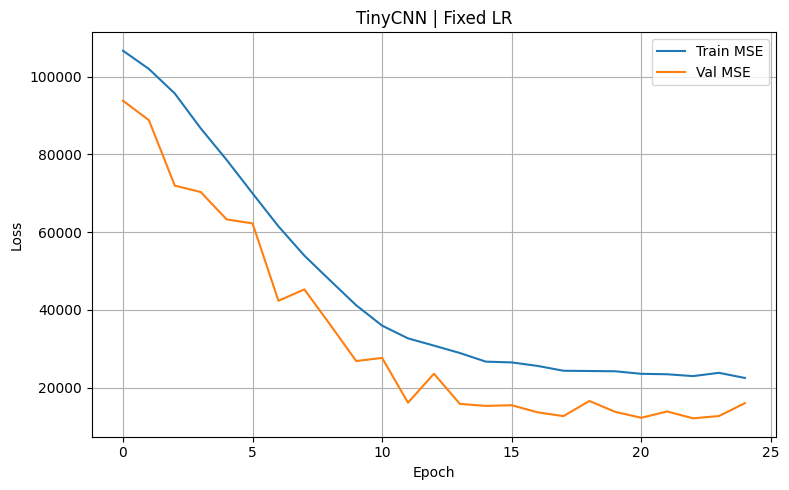

In [12]:
train_tiny_cnn()

In [ ]:
import pandas as pd, torch, numpy as np
from torch.utils.data import DataLoader

@torch.no_grad()
def predict_and_export_kaggle(model, test_csv, root_dir, out_csv,
                              mode="rgb+drgb", batch_size=8, num_workers=0, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval().to(device)

    test_ds = RGBDUnifiedDataset(test_csv, mode=mode, root_dir=root_dir, augment=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    ids, preds = [], []
    for x, _, dish_id in test_loader:       
        x = x.to(device, non_blocking=True)
        yhat = model(x).squeeze(1).detach().cpu().numpy()
        ids.extend(dish_id)
        preds.extend(yhat.tolist())

    sub = pd.DataFrame({"ID": ids, "Value": preds})
    sub.to_csv(out_csv, index=False)
    print(f"Saved Kaggle submission to: {out_csv}")


In [13]:
import os, csv, random, math, time
from typing import Tuple, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------- TinyCNN ----------------------
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch, eps=1e-5, momentum=0.1)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class TinyCNN(nn.Module):
    def __init__(self, in_ch=3, widths=(24,48,96,128), dropout=0.3, out_dim=1):
        super().__init__()
        w1,w2,w3,w4 = widths
        self.stem  = nn.Sequential(ConvBNReLU(in_ch,w1,3,2,1), ConvBNReLU(w1,w1,3,1,1))
        self.s1    = nn.Sequential(ConvBNReLU(w1,w2,3,2,1),  ConvBNReLU(w2,w2,3,1,1))
        self.s2    = nn.Sequential(ConvBNReLU(w2,w3,3,2,1),  ConvBNReLU(w3,w3,3,1,1))
        self.s3    = nn.Sequential(ConvBNReLU(w3,w4,3,2,1),  ConvBNReLU(w4,w4,3,1,1))
        self.drop  = nn.Dropout(dropout)
        self.fc1   = nn.Linear(w4, 128)
        self.fc2   = nn.Linear(128, out_dim)
    def forward(self, x):
        f = self.s3(self.s2(self.s1(self.stem(x))))
        z = F.adaptive_avg_pool2d(f, 1).flatten(1)
        z = self.drop(F.relu(self.fc1(z), inplace=True))
        return self.fc2(z)

# ---------------------- Dataset ----------------------
class RGBDataset(Dataset):
    """CSV columns: dish_id,label,rgb_path"""
    def __init__(self, csv_file, out_size=(384,384), augment=True,
                 mean_rgb=(0.485,0.456,0.406), std_rgb=(0.229,0.224,0.225)):
        super().__init__()
        self.H, self.W = out_size
        self.augment = augment

        self.rows = []
        with open(csv_file, "r") as f:
            reader = csv.reader(f)
            header = next(reader)
            col = {h:i for i,h in enumerate(header)}
            for r in reader:
                self.rows.append({
                    "dish_id": r[col["dish_id"]],
                    "label": float(r[col["label"]]),
                    "rgb": r[col["rgb_path"]].replace("\\", "/"),
                })

        self.mean_rgb = torch.tensor(mean_rgb).view(3,1,1)
        self.std_rgb  = torch.tensor(std_rgb ).view(3,1,1)

    def _load_img(self, p): return TF.to_tensor(Image.open(p).convert("RGB"))

    def _augment(self, img):
        scale = random.uniform(0.7, 1.0)
        h,w = img.shape[-2:]
        th,tw = int(h*scale), int(w*scale)
        i = random.randint(0, h-th) if th < h else 0
        j = random.randint(0, w-tw) if tw < w else 0
        img = TF.resized_crop(img, i, j, th, tw, (self.H,self.W))
        ang = random.uniform(-8,8)
        img = TF.rotate(img, ang)
        if random.random() < 0.5: img = TF.hflip(img)
        img = TF.adjust_brightness(img,1+random.uniform(-0.2,0.2))
        img = TF.adjust_contrast(img,1+random.uniform(-0.2,0.2))
        img = TF.adjust_saturation(img,1+random.uniform(-0.2,0.2))
        img = TF.adjust_hue(img,random.uniform(-0.04,0.04))
        return img

    def __getitem__(self, idx):
        row = self.rows[idx]
        y = torch.tensor([row["label"]], dtype=torch.float32)
        rgb = self._load_img(row["rgb"])
        if self.augment:
            rgb = self._augment(rgb)
        else:
            rgb = TF.resize(rgb, (self.H,self.W))
        rgb = (rgb - self.mean_rgb) / (self.std_rgb + 1e-6)
        return rgb, y, row["dish_id"]

    def __len__(self): return len(self.rows)

# ---------------------- Utils ----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def make_loader(dataset, batch_size, shuffle, drop_last):
    num_workers = 0
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=num_workers, pin_memory=torch.cuda.is_available(),
                      drop_last=drop_last)

# ---------------------- Eval / Train ----------------------
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); mse_sum=mae_sum=n=0.0
    for x,y,_ in loader:
        x,y=x.to(device, non_blocking=True),y.to(device, non_blocking=True)
        p=model(x)
        mse_sum+=F.mse_loss(p,y,reduction="sum").item()
        mae_sum+=torch.abs(p-y).sum().item(); n+=y.size(0)
    return {"MSE":mse_sum/n,"MAE":mae_sum/n}

def train_one_epoch(model, loader, optimizer, device, max_grad_norm=1.0):
    model.train()
    total, n = 0.0, 0
    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        pred = model(x)
        loss = F.mse_loss(pred, y)
        loss.backward()
        if max_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        total += loss.item() * x.size(0)
        n     += x.size(0)
    return total / max(1, n)

# ---------------------- Main ----------------------
def train_tiny_cnn_only_color():
    set_seed(7)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_csv = "train_index.csv"
    idx = list(range(len(RGBDataset(train_csv, augment=False))))
    random.shuffle(idx)
    k = max(1, int(0.2 * len(idx)))
    val_idx, train_idx = idx[:k], idx[k:]

    train_full = RGBDataset(train_csv, augment=True)
    val_full   = RGBDataset(train_csv, augment=False)
    train_ds = Subset(train_full, train_idx)
    val_ds   = Subset(val_full,   val_idx)

    train_loader = make_loader(train_ds, batch_size=64, shuffle=True,  drop_last=True)
    val_loader   = make_loader(val_ds,   batch_size=64, shuffle=False, drop_last=False)

    model = TinyCNN(in_ch=3, widths=(24,48,96,128), dropout=0.3, out_dim=1).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

    train_losses, val_losses = [], []
    best_val = float("inf")
    EPOCHS = 35

    for ep in range(1, EPOCHS + 1):
        tr = train_one_epoch(model, train_loader, optimizer, device)
        val = evaluate(model, val_loader, device)
        train_losses.append(tr); val_losses.append(val["MSE"])
        print(f"Epoch {ep:03d} | Train {tr:.4f} | Val MSE {val['MSE']:.4f} | Val MAE {val['MAE']:.2f}")
        if val["MSE"] < best_val:
            best_val = val["MSE"]
            torch.save({
                "model": model.state_dict(),
                "mode": "rgb",
                "in_ch": 3,
            }, "tinycnn_rgb_best.pth")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train MSE")
    plt.plot(val_losses, label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("TinyCNN (RGB Only)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [ ]:
train_tiny_cnn_only_color()